# Final Project AAI-520: **QA Companion**

In [ ]:
! pip install transformers evaluate datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pprint import pprint
import numpy as np
import json
import transformers
from transformers import (AutoTokenizer, AutoModelForQuestionAnswering,
                          DataCollatorWithPadding,
                          Trainer, TrainingArguments)
from datasets import Dataset, DatasetDict
from datasets import load_dataset
import torch
from sklearn.model_selection import train_test_split
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

**QA Companion** is an advanced generative chatbot designed to provide robust and dynamic interactions through the power of natural language processing. This application leverages BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art foundation model, to enhance its understanding and generation of contextually rich responses. The chatbot is trained on the Stanford Question Answering Dataset (SQuAD), a highly reputable dataset that empowers the model to process and respond to user queries with a high degree of precision.

To offer an intuitive user experience, QA Companion is deployed in an interactive interface built using Streamlit. This interface enables real-time user engagement with the model, allowing for fluid and seamless conversations. The synergy between advanced AI architecture and user-friendly design makes this project an exemplary showcase of deep learning applied to natural language understanding.

## Data Exploration and Preprocessing

In order to get a better understanding of the structure and content of the SQuAD, our team explored two approaches for handling the data: directly processing the raw JSON files from the SQuAD website and utilizing the Hugging Face API to load the SQuAD. When exploring the raw JSON files, we crafted a function that iterates through the file, extracting key features such as “context”, “question”, “answer” and “answer start” and creating a dataset that is easily compatible with the Hugging Face Trainer API. These features are essential for supplying the BERT model with robust inputs for downstream question-answering tasks and ensuring a smooth fine-tuning process.

The latter of our data exploration options was fairly simple, as the Datasets library handled a majority of the heavy lifting for us. This process involved loading the SQuAD from the Datasets library and conducting training and testing splits from there. It’s important to note that the training data consisted of nearly 88,000 instances and the testing data consisted of nearly 35,000 instances. Unfortunately, we do not have access to a GPU cluster strong enough to train all of these examples in a timely manner, so we chose to downsample.



### Loading the JSON File

Here we are loading the JSON data from our shared folder and using JSON parsing techniques along with some of the functions from the "datasets" library to convert our raw JSON files to a format that is suitable for Hugging Face.

In [ ]:
VALIDATION_PATH = '/content/drive/MyDrive/AAI-520 Final Project (NLP & Generative AI)/Code/data/dev-v1.1.json'
TRAIN_PATH = '/content/drive/MyDrive/AAI-520 Final Project (NLP & Generative AI)/Code/data/train-v1.1.json'

### Converting our JSON to a HF Compatible Format

In [ ]:
'''
We created a function to transform our raw JSON files from the SQuAD dataset
into a format that is directly compatible with Hugging Face's Trainer API.

This process involved extracting all of the relevant information from the JSON
files including: Contextual information, Questions, Answers and a few other
metadata values derived from some of our primary features (answer_start).
'''
def squad_json_to_dataset(squad_file_path):
    with open(squad_file_path, 'r') as file:
        squad_dict = json.load(file)

    contexts = []
    questions = []
    answers = []
    answer_starts = []

    # Extract relevant information from the SQuAD structure
    for article in squad_dict['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                # Handle the case of multiple answers (e.g., for training data)
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer['text'])
                    answer_starts.append(answer['answer_start'])

    # Create a Hugging Face Dataset from the extracted lists
    squad_dataset = Dataset.from_dict({
        'context': contexts,
        'question': questions,
        'answer': answers,
        'answer_start': answer_starts,
    })

    return squad_dataset

# Convert train and validation JSON files
train_dataset = squad_json_to_dataset(TRAIN_PATH) #TODO: CHANGE AFTER TESTING !!!!
validation_dataset = squad_json_to_dataset(VALIDATION_PATH)

# Create a DatasetDict with 'train' and 'validation' splits
squad_datasets = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset
})

# Check the structure of the dataset
print(squad_datasets)

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer', 'answer_start'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['context', 'question', 'answer', 'answer_start'],
        num_rows: 34726
    })
})


In [ ]:
# Splitting up training and validation examples from our JSON data
training = squad_datasets['train']
validation = squad_datasets['validation']

print("Training example")
print('===================================')
pprint(training[0])
print()
print("Validation example:")
print('===================================')
pprint(validation[0])

Training example
{'answer': 'Saint Bernadette Soubirous',
 'answer_start': 515,
 'context': 'Architecturally, the school has a Catholic character. Atop the '
            "Main Building's gold dome is a golden statue of the Virgin Mary. "
            'Immediately in front of the Main Building and facing it, is a '
            'copper statue of Christ with arms upraised with the legend '
            '"Venite Ad Me Omnes". Next to the Main Building is the Basilica '
            'of the Sacred Heart. Immediately behind the basilica is the '
            'Grotto, a Marian place of prayer and reflection. It is a replica '
            'of the grotto at Lourdes, France where the Virgin Mary reputedly '
            'appeared to Saint Bernadette Soubirous in 1858. At the end of the '
            'main drive (and in a direct line that connects through 3 statues '
            'and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear 

### Using the Datasets Library to Load SQuAD

In [ ]:
squad_dataset = load_dataset("squad")

train_dataset = squad_dataset["train"]
split_dataset = squad_dataset["validation"].train_test_split(test_size=0.2)
validation_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
print("Training instances:",len(train_dataset))
print("Validation instances:",len(validation_dataset))
print()
print("SQuAD Training example")
print('===================================')
print(train_dataset[0])
print()
print("SQuAD Validation example:")
print('===================================')
print(validation_dataset[0])
print()
print("Keys:",train_dataset[0].keys())

Training instances: 87599
Validation instances: 8456

SQuAD Training example
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], '

## Instantiating Model and Tokenizer

For tokenization, we were able to initially instantiate the BERT tokenizer provided by Hugging Face. This tokenizer efficiently handles the task of breaking down the input text (both questions and context) into tokens that the BERT model can process. The tokenizer also provides features like truncation, ensuring that the text does not exceed the model's token limit, and padding, which aligns the length of all tokenized inputs for batch processing. Another key feature is the return of offset mappings, which allows us to track the positions of tokens relative to the original input text, a crucial aspect when aligning answer spans in question-answering tasks. Our preprocessing function encapsulates all of the aforementioned capabilities of the BERT tokenizer by providing the ability to tokenize our inputs, retrieve and process offset mappings, and aligning the answer span with the context, ensuring consistency and relevant inputs for our training phase.


In [ ]:
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## QA Tokenization

After splitting our data, we then applied our BERT tokenizer to the question and context pairs so that we were able to convert the pairs into input features for our question answering model. The tokenization process involved intitializing the BertTokenizer along with a few parameters and applying this function to our training and testing datasets in batches. We separated this process into 2 functions, one for properly displaying our sequence length distribution and the other for the actual question answering task.

In [ ]:
def squad_eda_preprocess_function(examples,tokenizer):
    inputs = tokenizer(
        examples['question'],
        examples['context'],
        truncation = False, # Setting truncation to false
        padding = False
    )
    return inputs

def squad_preprocess_function(examples):
    questions = examples['question']
    contexts = examples['context']

    # Step 1 Get Tokens for QUESTIONs + CONTEXTs.
    # Outputs at this stage are "input_ids", "attention_mask", "offset_mappings"
    inputs = tokenizer(
        questions,
        contexts,
        max_length=384, # discussed above
        truncation="only_second", # truncate context if longer than 384
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True, # needed to find answer text positions in a set of tokens
        padding="max_length",
    )



    # Step 2 Based on Offset Mappings from Tokenization, extract start and end positions of final answer
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        #start_origs.append

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs


### Downsampling and Applying Preprocessing Functions

In [ ]:
%%time
# Setting Number of Samples per Group
NUM_SAMPLES_TRAINING = 40_000
NUM_SAMPLES_VALIDATION =8_000
NUM_SAMPLES_TEST = 100
RANDOM_SEED = 42

# Downsampling
train_subset = train_dataset.shuffle(seed=RANDOM_SEED).select(range(NUM_SAMPLES_TRAINING))
validation_subset = validation_dataset.shuffle(seed=RANDOM_SEED).select(range(NUM_SAMPLES_VALIDATION))
test_subset = test_dataset.shuffle(seed=RANDOM_SEED).select(range(NUM_SAMPLES_TEST))

# Applying Preprocessing Functions

tokenized_train = train_subset.map(squad_preprocess_function, batched=True,
                                   remove_columns=validation_subset.column_names)
tokenized_validation = validation_subset.map(squad_preprocess_function, batched=True,
                                             remove_columns=validation_subset.column_names)

tokenized_train_EDA = train_subset.map(squad_eda_preprocess_function,
                                        fn_kwargs={"tokenizer": tokenizer},
                                        remove_columns=train_dataset.column_names)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 1min 25s, sys: 610 ms, total: 1min 26s
Wall time: 52.9 s


### Sequence Length Distribution on Tokens
The question/context pairs in the train_set were tokenized to varying sequence lengths - from a minimum of 36 to a max of 882.

The mean length is 176.5 tokens with a standard_deviation of 67.64.

The histogram shows that a huge majority of the samples were tokenized to sequence lengths less than 400.

99 percentile is at sequence length 400.

In terms of variation from the mean, sequence lengths less than 379.42 would give z-scores <3.0 - i.e. less than +3 stds from the mean

Based on this, a maximum sequence length is chosen for this tokenizer between 379 and 400.

For efficient memory utilization, the next power-of-2 multiple after 379 is chosen - i.e. 384 = 3 x 2^7

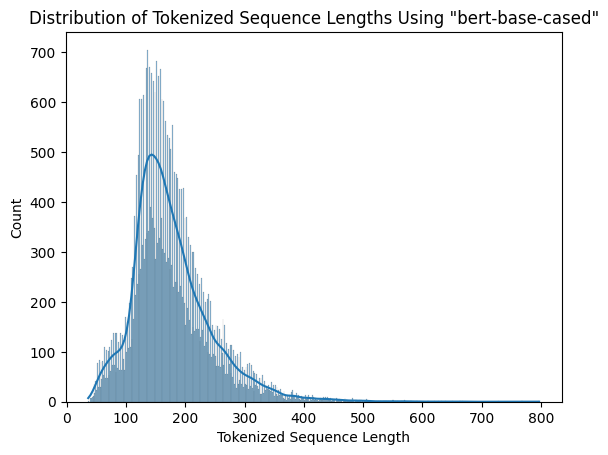

Min Length: 36

Max Length: 797

Mean Length: 176.697625

Standard Deviation: 67.13909140254562

Sequence Length (z-scores < 3.0): 378.1148992076369

Sequence Length (99% percentile): 397.0



In [ ]:
'''
Checking the distribution of sequence lengths after tokenizing
'question' and 'context' pairs
'''

def show_tokenizedLengthDist(inputsList, tokenizer):
    temp = [len(item) for item in inputsList]

    sns.histplot(data=temp, kde = True, bins=len(np.unique(temp)))

    plt.xlabel('Tokenized Sequence Length')
    plt.ylabel('Count')
    plt.title(f'Distribution of Tokenized Sequence Lengths Using "{tokenizer.name_or_path}"')
    plt.show()

    mean = np.mean(temp)
    std_dev = np.std(temp)

    print(f"Min Length: {min(temp)}\n")
    print(f"Max Length: {max(temp)}\n")
    print(f"Mean Length: {mean}\n")
    print(f"Standard Deviation: {std_dev}\n")
    print(f"Sequence Length (z-scores < 3.0): {mean + 3 * std_dev}\n")
    print(f"Sequence Length (99% percentile): {np.percentile(temp, 99)}\n")

# show the distribution of the tokenized sequence lengths
show_tokenizedLengthDist(tokenized_train_EDA['input_ids'], tokenizer = tokenizer)

In [ ]:
''''
Creating our model path for training
'''
ft_model_path = f"./model_train_v4-2_{NUM_SAMPLES_TRAINING}_val{NUM_SAMPLES_VALIDATION}"
ft_model_path_TR = f"./model_train_v4-2_TR_{NUM_SAMPLES_TRAINING}_val{NUM_SAMPLES_VALIDATION}"

## Fine Tuning | Model Training

In [ ]:
%%time

# Setting up the training configuration for question answering
training_args = TrainingArguments(
    output_dir=ft_model_path_TR,
    save_strategy="epoch",
    evaluation_strategy="epoch", # Eval at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16, # Train Batch Size -- 16 samples at a time
    per_device_eval_batch_size=16, #Test Batch Size -- 16 samples at a time
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
)

history = trainer.train()
# Saving the fine-tuned model
trainer.save_model(ft_model_path)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.171200,1.122206
2,0.868200,1.102064
3,0.626400,1.176427


CPU times: user 32min 36s, sys: 11.8 s, total: 32min 48s
Wall time: 33min 3s


### Saving Training History

Here, we are saving the history from our fine-tuning process. This is key for tracking, analyzing and improving the fine-tuning process.

In [ ]:
# Saving the training history
with open(ft_model_path_TR + 'training_history.json', 'w') as f:
    json.dump(trainer.state.log_history, f)


### Load Saved Fine-Tuned Tokenizer and Model

In [ ]:
# Loading the fine-tuned model from the intended path
model = AutoModelForQuestionAnswering.from_pretrained(ft_model_path)
tokenizer = AutoTokenizer.from_pretrained(ft_model_path)

### Define Prediction Function

In [ ]:
def predictTextAnswers(prompts, model, tokenizer):
    # returns the predicted answer (text) given the context and question provided in the prompt.
    # prompt is a sequence of dicts (can be of length 1).
    # Each dict must contain the keys 'question' and 'answer', and may contain others
    # If the key 'id' is provided, it will be returned (needed for evaluation function)

    question = prompts['question']
    context = prompts['context']

    # use GPU if available
    if torch.backends.mps.is_available():
        print("MPS device found.")
        torch.mps.empty_cache()
        device = torch.device("mps")
    else:
        print("MPS device not found.")
        device = torch.device("cpu")
    model.to(device)

    question = prompts['question']
    context = prompts['context']

    # tokenize prompt
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        padding="max_length",
        return_tensors="pt"
    ).to(device)


    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    # Use positions with max probabilities
    answer_start = torch.argmax(outputs.start_logits, dim=-1)
    answer_end = torch.argmax(outputs.end_logits, dim=-1)

    # Convert token positions into text spans for each sample in the batch
    answer_texts = []
    for i, input_ids in enumerate(inputs['input_ids']):
        answer_text = tokenizer.convert_tokens_to_string(
                        tokenizer.convert_ids_to_tokens(input_ids[answer_start[i]:answer_end[i]+1]))
        answer_texts.append(answer_text)

    # include 'id' key in the return value if it exists in the input prompt
    predicted_answer = {}
    if 'id' in prompts:
        predicted_answer['id'] = prompts['id']
    predicted_answer['prediction_text'] = answer_texts

    return predicted_answer

## Model Evaluation

In [ ]:
# define function that computes for squad metrics given a dataset in squad format
def evaluateModelWrapper(data_set, model, tokenizer, batch_size = 64):
    # Step1. get predicted text answers using map functionality and predictTextAnswers() function above (for batch processing)
    predicted_answers  = data_set.map(predictTextAnswers,
                                   fn_kwargs={"model": model,
                                              "tokenizer": tokenizer},
                                   batched=True, batch_size = batch_size,
                                   remove_columns=data_set.column_names )

    # Step2. create reference answers from the input test_set
    reference_answers = []
    for i, answer in enumerate(data_set):
        reference_answer = {'id': data_set[i]['id'],
                            'answers': data_set[i]['answers']
                            }
        reference_answers.append(reference_answer)


    # Step 3. Use 'evaluate' library to calculate metrics universally used on Squad Dataset
    squad_metric = load("squad")
    results = squad_metric.compute(predictions=predicted_answers,
                                   references=reference_answers)

    # Step 4. Print metrics
    print(f"Number of Samples: {len(predicted_answers)}\n")
    print(f"Exact Match: {results['exact_match']}")
    print(f"F1 Score: {results['f1']}")

    return

In [ ]:
%%time
evaluateModelWrapper(test_subset, model, tokenizer)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Number of Samples: 100

Exact Match: 67.0
F1 Score: 77.54721730797583
CPU times: user 1min 12s, sys: 14.8 s, total: 1min 27s
Wall time: 17.7 s


### Single Prompt Evaluation
Here, we are testing out a few question and context pairs and evaluating our newly fine-tuned model's ability to digest the context, sythesize the question and extract the relevant answer.

We fed in several prompts to our prettyPrintSingleShotQA function that is intended to return the context, question and answer extracted from the context. Below, we were able to analyze the predictions from several distinct prompts and to our delight, the model seemed to extract the correct answer pretty well!

In some instances, we were able to identify why the exact match metric can be harsh at times because there were a few instances that produced the correct answer, but it wouldn't be classified as an exact match due to a few nuanced changes in the returned answer.

In [ ]:
# define a fuction that prints nicely a single shot prompt containig context & question, and the predicted answer
def prettyPrintSingleShotQA(prompt:str, model:str, tokenizer:str) -> None:
    pred_answer = predictTextAnswers(prompt, model, tokenizer)['prediction_text'][0]
    # print Context, Question, Answer
    print(f"CONTEXT:\n{prompt['context']}\n")
    print(f"QUESTION:\n{prompt['question']}\n")
    print(f"MODEL ANSWER:\n{pred_answer}\n")

In [ ]:
prompts = [
    {
        'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
        'context': '''Architecturally, the school has a Catholic character.
        Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary.
        Immediately in front of the Main Building and facing it, is a copper
        statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
        Next to the Main Building is the Basilica of the Sacred Heart. Immediately
        behind the basilica is the Grotto, a Marian place of prayer and reflection.
         It is a replica of the grotto at Lourdes, France where the Virgin Mary
         reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of
         the main drive (and in a direct line that connects through 3 statues and
          the Gold Dome), is a simple, modern stone statue of Mary.'''
    },
    {
        'question': "What is my first name?",
        'context': "I have many nicknames - Nico, Loco, Kulas, Jop. But my real name is Geoffrey."
    },
    {
        'question': "Who is in Group 2 in MSAAI-520?",
        'context': "Arin, Diego and Geoffrey are in Group 2 in MSAAI-520"
    },
    {
        'question': """What significant contribution did Charles Darwin's
        observations on the Galápagos Islands make to scientific understanding?""",
        'context': """The Galápagos Islands, located about 1000 km off the coast
         of Ecuador, are renowned for their unique ecosystem and diverse
          wildlife. Charles Darwin's observations on these islands played a
          crucial role in the development of his theory of evolution by natural
          selection. The islands are home to many endemic species, including giant
          tortoises, marine iguanas, and various types of finches. In 1978,
          UNESCO declared the Galápagos Islands a World Heritage Site, recognizing
          their exceptional natural beauty and scientific importance."""
    },
    {
        'question': 'What planet was recently reclassified as a dwarf planet?',
        'context': """Prior to 2006, the International Astronomical Union (IAU)
        used to consider the Solar System to have 9 planets orbiting the Sun.
        In order of increasing orbital distance from the Sun, the planets were
        Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and Pluto.
        However, in 2006, the IAU reclassified Pluto as a dwarf planet because it
        has not cleared objects and debris in its orbital path. Therefore,
        currently, there are only 8 considered as planets in the solar system."""
    }
]


In [ ]:
for prompt in prompts:
    prettyPrintSingleShotQA(prompt, model, tokenizer)

CONTEXT:
Architecturally, the school has a Catholic character.
        Atop the Main Building's gold dome is a golden statue of the Virgin Mary.
        Immediately in front of the Main Building and facing it, is a copper
        statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".
        Next to the Main Building is the Basilica of the Sacred Heart. Immediately
        behind the basilica is the Grotto, a Marian place of prayer and reflection.
         It is a replica of the grotto at Lourdes, France where the Virgin Mary
         reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of
         the main drive (and in a direct line that connects through 3 statues and
          the Gold Dome), is a simple, modern stone statue of Mary.

QUESTION:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

MODEL ANSWER:
Saint Bernadette Soubirous

CONTEXT:
I have many nicknames - Nico, Loco, Kulas, Jop. But my real name is Geoffrey.

QUES